In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier
import joblib

1. Load the Dataset

In [2]:
# Load the dataset
file_path = 'Job_ML_Filtered.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Display dataset structure
print(data.head())
print(data.info())


   Job Role     Experience Qualifications Salary Range    location  \
0         1  5 to 15 Years         M.Tech    $59K-$99K     Douglas   
1         2  2 to 12 Years            BCA   $56K-$116K    Ashgabat   
2         3  0 to 12 Years            PhD   $61K-$104K       Macao   
3         4  4 to 11 Years            PhD    $65K-$91K  Porto-Novo   
4         5  1 to 12 Years            MBA    $64K-$87K    Santiago   

            Country  Work Type  Company Size Job Posting Date Preference  ...  \
0       Isle of Man     Intern         26801       2022-04-24     Female  ...   
1      Turkmenistan     Intern        100340       2022-12-19     Female  ...   
2  Macao SAR, China  Temporary         84525       2022-09-14       Male  ...   
3             Benin  Full-Time        129896       2023-02-25     Female  ...   
4             Chile     Intern         53944       2022-10-11     Female  ...   

                 Contact                     Job Title  \
0   001-381-930-7517x737  Digital 

In [3]:
data.columns

Index(['Job Role', 'Experience', 'Qualifications', 'Salary Range', 'location',
       'Country', 'Work Type', 'Company Size', 'Job Posting Date',
       'Preference', 'Contact Person', 'Contact', 'Job Title', 'Role',
       'Job Portal', 'Job Description', 'Benefits', 'skills',
       'Responsibilities', 'Company', 'Company Profile'],
      dtype='object')

2. Data Preprocessing

Handle Missing Values

In [4]:
import pandas as pd

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows/columns (based on context)
data.fillna(method='ffill', inplace=True)  # Example: Forward fill

# Replace with the mode (most frequent value)
data['Company Profile'].fillna(data['Company Profile'].mode()[0], inplace=True)



Job Role            0
Experience          0
Qualifications      0
Salary Range        0
location            0
Country             0
Work Type           0
Company Size        0
Job Posting Date    0
Preference          0
Contact Person      0
Contact             0
Job Title           0
Role                0
Job Portal          0
Job Description     0
Benefits            0
skills              0
Responsibilities    0
Company             0
Company Profile     2
dtype: int64


C:\Users\cheta\AppData\Local\Temp\ipykernel_16472\3919559120.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Example: Forward fill
C:\Users\cheta\AppData\Local\Temp\ipykernel_16472\3919559120.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Company Profile'].fillna(data['Company Profile'].mode()[0], inplace=True)


Encode Categorical Features

In [5]:
# Encode Categorical Features
le = LabelEncoder()
categorical_columns = ['Experience', 'Qualifications', 'location', 'Job Posting Date',
                       'Contact Person', 'Contact', 'Role', 'Job Title', 'Responsibilities',
                       'Job Description', 'Benefits', 'skills', 'Company Profile',
                       'Company', 'Preference']

for col in categorical_columns:
    data[col] = le.fit_transform(data[col])

# One-Hot Encoding
data = pd.get_dummies(data, columns=['Job Portal', 'Country', 'Work Type'], drop_first=True)

Feature Engineering

In [6]:
# Feature Engineering
# Process Salary Range
data['Salary Range'] = data['Salary Range'].str.replace('K', '').str.replace('$', '', regex=False)
data[['Min_Salary', 'Max_Salary']] = data['Salary Range'].str.split('-', expand=True).apply(pd.to_numeric, errors='coerce')
data['Salary'] = (data['Min_Salary'] + data['Max_Salary']) / 2
data.drop(['Salary Range', 'Min_Salary', 'Max_Salary','location', 'Company Size',
       'Job Posting Date', 'Contact Person', 'Contact'], axis=1, inplace=True)

3. Split Data into Features and Target

In [7]:
# 3. Split Data into Features and Target
X = data[['Experience', 'Qualifications', 'skills']]
y = data['Preference']


In [8]:
# 4. Feature Selection
#selector = SelectKBest(score_func=chi2, k=5)  # Select best 15 features
#X_new = selector.fit_transform(X, y)
#selected_features = X.columns[selector.get_support()]
#X_selected = X[selected_features]

In [9]:
#selected_features

In [10]:
#X_selected = X[selected_features]

4. Split Dataset into Training and Testing Sets

In [11]:
# 5. Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

5. Model Selection

In [12]:
# 6. Address Class Imbalance
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [13]:
# 7. Scaling Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# 8. Model Selection & Training
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

6. Model Evaluation

In [15]:
# 9. Model Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.355
              precision    recall  f1-score   support

           0       0.38      0.32      0.34        73
           1       0.41      0.42      0.41        71
           2       0.28      0.32      0.30        56

    accuracy                           0.35       200
   macro avg       0.35      0.35      0.35       200
weighted avg       0.36      0.35      0.36       200



7. Hyperparameter Tuning

In [16]:
# 10. Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}
grid_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, n_iter=10, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


8. Feature Importance

TypeError: only length-1 arrays can be converted to Python scalars

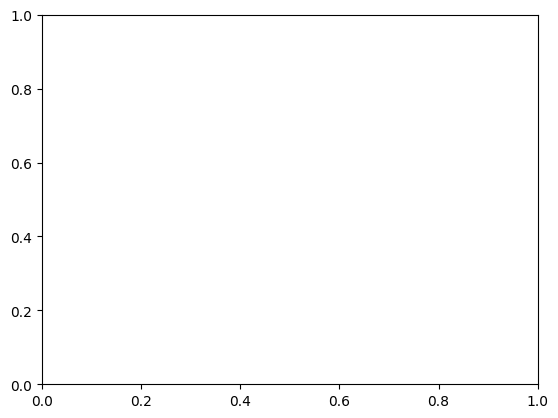

In [18]:
# 11. Feature Importance
importances = best_model.feature_importances_
features = X
sorted_indices = np.argsort(importances)
plt.barh(np.array(features)[sorted_indices], importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.show()

10. Validation

In [19]:
# 12. Cross-Validation
scores = cross_val_score(best_model, X, y, cv=5)
print(f"Cross-Validation Accuracy: {scores.mean()}")


Cross-Validation Accuracy: 0.3212713567839196


11.  Deployment

In [20]:

# 13. Deployment
joblib.dump(best_model, 'final_xgb_model.pkl')


['final_xgb_model.pkl']